# SQL european football analysis

The goal of this project is to explore the data of a database containing information on European Football matches and leagues. Using, among others, CASE, JOINS, and subqueries I try to disclose interesting insights about specific football teams.

1. Setting connection and checking tables;
2. Specific analysis for Ajax;
3. Class object for analyzing team of choice.

Source: https://www.kaggle.com/code/raylondwellman/sql-data-analysis2/data

#### 1. Setting the connection and checking tables

In [5]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('eu_football_db.sqlite')

In [2]:
conn.execute("SELECT name FROM sqlite_master WHERE type = 'table' ORDER BY 1").fetchall()

[('Country',),
 ('League',),
 ('Match',),
 ('Player',),
 ('Player_Attributes',),
 ('Team',),
 ('Team_Attributes',),
 ('sqlite_sequence',)]

#### 2. EDA for specific team

For this project, I will focus on the Dutch football team Ajax. I will perform several queries, to reveal interesting insights into the performance of this team over the period spanned by the data.

First, let's take quick look at some of the tables:

In [130]:
pd.read_sql("""SELECT * FROM Team LIMIT 3""", conn)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673,KRC Genk,GEN
1,2,9993,675,Beerschot AC,BAC
2,3,10000,15005,SV Zulte-Waregem,ZUL


In [131]:
pd.read_sql("""SELECT * FROM Match LIMIT 3""", conn)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.5,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75


In [15]:
# As teams are represented by an id, let's fetch the one corresponding to Ajax

conn.execute("""
            SELECT team_api_id FROM team
            WHERE team_long_name LIKE 'AJAX'""").fetchone()[0]

8593

In [16]:
# Let's see how many recorded matches there are, home and away

pd.read_sql("""
            SELECT 
            CASE WHEN home_team_api_id = 8593 THEN 'Home'
                 WHEN away_team_api_id = 8593 THEN 'Away'
                 ELSE 'Other'
            END AS home_or_away,
            COUNT(id) AS total_matches
            FROM match
            WHERE home_team_api_id = 8593
            OR away_team_api_id = 8593
            GROUP BY home_or_away
            """, conn)

,home_or_away,total_matches
0,Away,136
1,Home,136


In [29]:
# Team performance can differ per season as players come and leave. Let's see the performance over the years

season_perf = pd.read_sql("""
            SELECT season,
            COUNT(CASE WHEN home_team_api_id = 8593 AND home_team_goal > away_team_goal
                THEN id END) AS home_wins,
            COUNT(CASE WHEN away_team_api_id = 8593 AND away_team_goal > home_team_goal
                THEN id END) AS away_wins,
                
            COUNT(CASE WHEN home_team_api_id = 8593 AND home_team_goal < away_team_goal
                THEN id END) AS home_losses,
            COUNT(CASE WHEN away_team_api_id = 8593 AND away_team_goal < home_team_goal
                THEN id END) AS away_losses,   
                
            COUNT(CASE WHEN home_team_api_id = 8593 AND away_team_goal = home_team_goal
                THEN id END) AS home_draws,
            COUNT(CASE WHEN away_team_api_id = 8593 AND away_team_goal = home_team_goal
                THEN id END) AS away_draws
            FROM match
            GROUP BY season;
            """, conn)
season_perf

,season,home_wins,away_wins,home_losses,away_losses,home_draws,away_draws
0,2008/2009,13,8,1,7,3,2
1,2009/2010,16,11,0,3,1,3
2,2010/2011,13,9,2,3,2,5
3,2011/2012,12,11,1,3,4,3
4,2012/2013,11,11,1,1,5,5
5,2013/2014,13,7,1,2,3,8
6,2014/2015,12,9,2,3,3,5
7,2015/2016,13,12,1,1,3,4


Now, because we're focussing on Ajax only, let's make a new table dedicated to Ajax matches. This way, I won't have to work with home_team_api_id and away_team_api_id over and over again. I create a temporary table, because this is a very specific table, and we don't want to end up with a table for each specific team if we perform similar analyses for different teams.

In [211]:
conn.execute("""
            CREATE TEMPORARY TABLE ajax_matches AS
                SELECT match_api_id, season, t1.team_long_name as home_team, t2.team_long_name as away_team,
                home_team_goal, away_team_goal,
                CASE WHEN home_team_api_id = 8593 AND home_team_goal > away_team_goal THEN 1
                     WHEN away_team_api_id = 8593 AND home_team_goal < away_team_goal THEN 1
                     ELSE 0 END as win,
                CASE WHEN home_team_api_id = 8593 AND home_team_goal < away_team_goal THEN 1
                     WHEN away_team_api_id = 8593 AND home_team_goal > away_team_goal THEN 1
                     ELSE 0 END as loss,
                CASE WHEN home_team_api_id = 8593 AND home_team_goal = away_team_goal THEN 1
                     WHEN away_team_api_id = 8593 AND home_team_goal = away_team_goal THEN 1
                     ELSE 0 END as draw 
                FROM match
                JOIN team AS t1
                ON home_team_api_id = t1.team_api_id
                JOIN team AS t2
                ON away_team_api_id = t2.team_api_id
                WHERE home_team_api_id = 8593 or away_team_api_id = 8593;
            """)

In [212]:
pd.read_sql("""SELECT * FROM ajax_matches LIMIT 5""", conn)

,match_api_id,season,home_team,away_team,home_team_goal,away_team_goal,win,loss,draw
0,508304,2008/2009,Willem II,Ajax,2,1,0,1,0
1,523736,2008/2009,Ajax,Sparta Rotterdam,5,2,1,0,0
2,523745,2008/2009,Ajax,PSV,4,1,1,0,0
3,523754,2008/2009,AZ,Ajax,2,0,0,1,0
4,523764,2008/2009,Ajax,FC Utrecht,1,1,0,0,1


Now I have a table with all the Ajax matches with scores and the outcome from the perspective of Ajax.

In [139]:
season_perf = pd.read_sql("""
            SELECT season, 
            CASE WHEN home_team = 'Ajax' THEN 'home'
                 ELSE 'away' END AS home_away,
            SUM(win) AS wins, SUM(loss) AS losses, SUM(draw) AS draws
            FROM ajax_matches
            GROUP BY season, home_away;
            """, conn)
season_perf.head(3)

,season,home_away,wins,losses,draws
0,2008/2009,away,8,7,2
1,2008/2009,home,13,1,3
2,2009/2010,away,11,3,3


Plotting the data allows us to see better the trend over the years. For a team like Ajax, the main concern is the number of wins, but other teams might be more interested in number of non losses (wins + draws). Furthermore, playing at the home stadium is often considered an advantage.

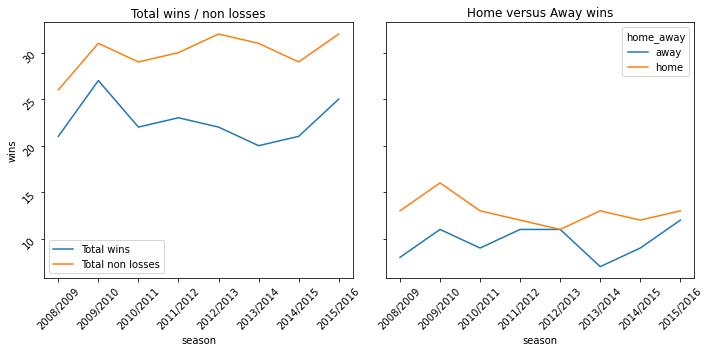

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

season_total = season_perf.groupby('season').sum().reset_index()

fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = 'row')

sns.lineplot(data = season_total, x = 'season', y = 'wins',
             label = 'Total wins', ax = ax [0])
sns.lineplot(data = season_total, x = 'season', y = season_total['wins'] +season_total['draws'],
             label = 'Total non losses', ax = ax [0])
ax[0].tick_params(rotation = 45)
ax[0].set_title('Total wins / non losses')


sns.lineplot(data = season_perf, x = 'season',y = 'wins', hue = 'home_away', ax = ax[1])
ax[1].tick_params(rotation = 45)
ax[1].set_title('Home versus Away wins')

plt.tight_layout();

We see that the seasons between 2009/2010 and 2015/2016 were tough ones for Ajax. The advantage of home versus away shows over all, but not for all seasons.

A more insightful statistics could be the percentage of wins.

In [166]:
season_perf_perc = pd.read_sql("""
            SELECT SEASON,
            CASE WHEN home_team = 'Ajax' THEN 'home'
                 ELSE 'away' END AS home_away,
            ROUND(AVG(win),2) as win_perc,
            ROUND(AVG(loss),2) as loss_perc,
            ROUND(AVG(draw),2) as draw_perc
            FROM ajax_matches
            GROUP BY season, home_away;
            """, conn)
season_perf_perc.head(3)

,season,home_away,win_perc,loss_perc,draw_perc
0,2008/2009,away,0.47,0.41,0.12
1,2008/2009,home,0.76,0.06,0.18
2,2009/2010,away,0.65,0.18,0.18


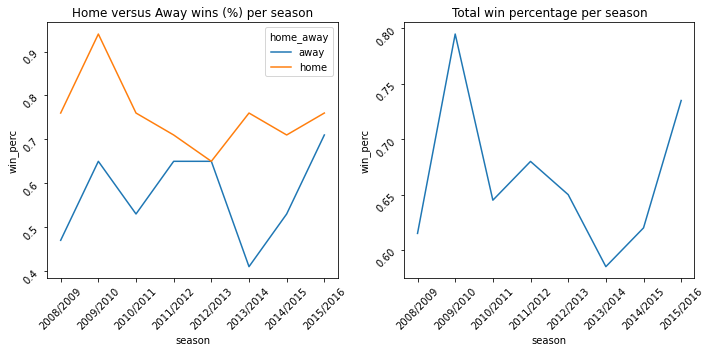

In [171]:
season_total = season_perf_perc.groupby('season').mean()

fig, ax = plt.subplots(1,2, figsize = (10,5))

sns.lineplot(data = season_perf_perc, x = 'season', y = 'win_perc', hue = 'home_away', ax = ax[0]);
ax[0].tick_params(rotation = 45)
ax[0].set_title('Home versus Away wins (%) per season')

sns.lineplot(data = season_total, x = 'season', y = 'win_perc', ax = ax[1])
ax[1].tick_params(rotation = 45)
ax[1].set_title('Total win percentage per season')

plt.tight_layout();

Let's see how the average number of goals differs per season:

In [177]:
pd.read_sql("""
            SELECT SEASON,
            ROUND(AVG(CASE WHEN home_team = 'Ajax' THEN home_team_goal END),2) AS home_goals,
            ROUND(AVG(CASE WHEN home_team = 'Ajax' THEN away_team_goal END),2) AS away_goals
            FROM ajax_matches
            GROUP BY season;
            """, conn)

,season,home_goals,away_goals
0,2008/2009,2.41,0.53
1,2009/2010,3.76,0.24
2,2010/2011,2.24,0.53
3,2011/2012,2.88,0.82
4,2012/2013,2.35,0.59
5,2013/2014,2.47,0.53
6,2014/2015,2.18,0.65
7,2015/2016,2.88,0.71


Teams within competitions have different levels. Therefore, it makes sense some opponents are tougher for Ajax than others:

In [187]:
opponent_overview = pd.read_sql(""" SELECT
                CASE WHEN home_team = 'Ajax' THEN away_team
                     ELSE home_team END AS opponent,
                SUM(win) AS wins, SUM(loss) AS losses, SUM(draw) AS draws,
                SUM(CASE WHEN home_team = 'Ajax' THEN home_team_goal
                         ELSE away_team_goal END) AS goals_for,
                SUM(CASE WHEN home_team <> 'Ajax' THEN home_team_goal
                         ELSE away_team_goal END) AS goals_against
                FROM ajax_matches
                GROUP BY opponent""", conn)
opponent_overview.head(3)

,opponent,wins,losses,draws,goals_for,goals_against
0,ADO Den Haag,10,2,4,32,10
1,AZ,8,4,4,34,20
2,De Graafschap,7,0,1,26,4


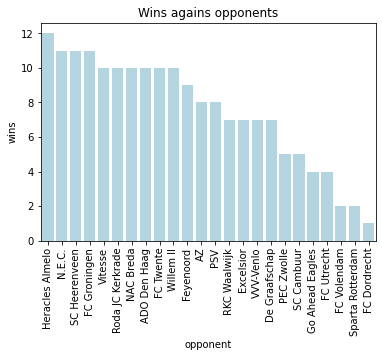

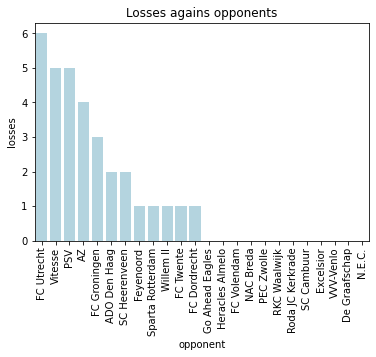

In [208]:
sns.barplot(data = opponent_overview.sort_values('wins', ascending = False), y = 'wins', x = 'opponent',
            color = 'lightblue')
plt.xticks(rotation = 90)
plt.title('Wins agains opponents')
plt.show()

sns.barplot(data = opponent_overview.sort_values('losses', ascending = False), y = 'losses', x = 'opponent',
            color = 'lightblue')
plt.xticks(rotation = 90)
plt.title('Losses agains opponents')
plt.show()

We can see there are a few teams Ajax seems to struggle agains and some teams that did not win once against Ajax during these seasons.

In [236]:
class analyze_team():
    """
    Class that enables team-specific analysis. 
        
    Argument = teamname
        
    Functions:
        1. check_team: control teamname query
        2. create_temp (must): create temp table for specific team
        3. season_perf: get wins, losses, draws per season for away and home
        4. season_perc: get % wins, losses, draws per season for away and home
        5. season_goals: get goals per season
        6. opponent_overview: get wins, losses, draws, goals, per season per opponent
    """
    
    def __init__(self, team):
        self.team_code = conn.execute(f"""
                                        SELECT team_api_id FROM team
                                        WHERE team_long_name LIKE '{team}'""").fetchone()[0]
        self.team = conn.execute(f"""
                                        SELECT team_long_name FROM team
                                        WHERE team_api_id = '{self.team_code}'""").fetchone()[0]
        self.table_name = str(self.team)+ 'table'
        
    def check_team(self):
        return self.team
    
    def create_temp(self):
        conn.execute(f"""
            CREATE TEMPORARY TABLE IF NOT EXISTS {self.table_name} AS
                SELECT match_api_id, season, t1.team_long_name as home_team, t2.team_long_name as away_team,
                home_team_goal, away_team_goal,
                CASE WHEN home_team_api_id = {self.team_code} AND home_team_goal > away_team_goal THEN 1
                     WHEN away_team_api_id = {self.team_code} AND home_team_goal < away_team_goal THEN 1
                     ELSE 0 END as win,
                CASE WHEN home_team_api_id = {self.team_code} AND home_team_goal < away_team_goal THEN 1
                     WHEN away_team_api_id = {self.team_code} AND home_team_goal > away_team_goal THEN 1
                     ELSE 0 END as loss,
                CASE WHEN home_team_api_id = {self.team_code} AND home_team_goal = away_team_goal THEN 1
                     WHEN away_team_api_id = {self.team_code} AND home_team_goal = away_team_goal THEN 1
                     ELSE 0 END as draw 
                FROM match
                JOIN team AS t1
                ON home_team_api_id = t1.team_api_id
                JOIN team AS t2
                ON away_team_api_id = t2.team_api_id
                WHERE home_team_api_id = {self.team_code} or away_team_api_id = {self.team_code};
            """)
        return 'Temp table created'

    def season_perf(self):
        return pd.read_sql(f"""
            SELECT season, 
            CASE WHEN home_team = '{self.team}' THEN 'home'
                 ELSE 'away' END AS home_away,
            SUM(win) AS wins, SUM(loss) AS losses, SUM(draw) AS draws
            FROM {self.table_name}
            GROUP BY season, home_away;
            """, conn)
    
    def season_perc(self):
        return pd.read_sql(f"""
                SELECT SEASON,
                CASE WHEN home_team = '{self.team}' THEN 'home'
                     ELSE 'away' END AS home_away,
                ROUND(AVG(win),2) as win_perc,
                ROUND(AVG(loss),2) as loss_perc,
                ROUND(AVG(draw),2) as draw_perc
                FROM {self.table_name}
                GROUP BY season, home_away;
                """, conn)
    
    def season_goals(self):
        return pd.read_sql(f"""
            SELECT SEASON,
            ROUND(AVG(CASE WHEN home_team = '{self.team}' THEN home_team_goal END),2) AS home_goals,
            ROUND(AVG(CASE WHEN home_team = '{self.team}' THEN away_team_goal END),2) AS away_goals
            FROM {self.table_name}
            GROUP BY season;
            """, conn)
    
    def opponent_overview(self):
        return pd.read_sql(f""" SELECT
                CASE WHEN home_team = '{self.team}' THEN away_team
                     ELSE home_team END AS opponent,
                SUM(win) AS wins, SUM(loss) AS losses, SUM(draw) AS draws,
                SUM(CASE WHEN home_team = '{self.team}' THEN home_team_goal
                         ELSE away_team_goal END) AS goals_for,
                SUM(CASE WHEN home_team <> '{self.team}' THEN home_team_goal
                         ELSE away_team_goal END) AS goals_against
                FROM {self.table_name}
                GROUP BY opponent""", conn)

In [232]:
test = analyze_team('Liverpool')
test.check_team()
test.create_temp()
test.opponent_overview()

,opponent,wins,losses,draws,goals_for,goals_against
0,Arsenal,2,6,8,24,28
1,Aston Villa,9,4,3,30,14
2,Birmingham City,1,0,3,8,3
3,Blackburn Rovers,5,1,2,16,9
4,Blackpool,0,2,0,2,4
5,Bolton Wanderers,7,1,0,17,7
6,Bournemouth,2,0,0,3,1
7,Burnley,4,0,0,11,0
8,Cardiff City,2,0,0,9,4
9,Chelsea,7,5,4,22,18
